In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import random
import sklearn
import collections
from sklearn.model_selection import train_test_split
import json
import pylab
from scipy.optimize import curve_fit
from tensorflow.keras import layers, Model
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from sklearn.metrics import roc_curve, auc

2024-04-06 02:03:30.391164: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-06 02:03:30.875899: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import tensorflow as tf

# Check GPUs available
gpus = tf.config.list_physical_devices('GPU')
print(f"GPUs Available: {gpus}")

# Check if TensorFlow is currently executing eagerly (which means operations are executed as they are defined and is the default mode in TF 2.x)
print(f"Eager execution: {tf.executing_eagerly()}")

# If you have GPUs listed and eager execution is enabled, then operations should automatically run on the GPU if possible.
# To test if TensorFlow will place tensors and operations on the GPU by default, you can create a simple operation and see where it is placed:
if gpus:
    with tf.device('/GPU:0'):
        a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
        print(a.device)
else:
    print("No GPU found!")

GPUs Available: []
Eager execution: True
No GPU found!


In [2]:
# This is the list that will hold all of the data (data22 and MC)

datasets = []
pass_L1 = []
tags = ['data', 'HHbbttHadHad', 'ZZ4lep', 'Ztautau', 'jjJZ4', 'jjJZ2', 'qqa', 'LLP', 'dark_jets', 'dark_photons']

In [3]:
# Read EB file
with h5py.File('../../../../ntuples/AOD_EB_ntuples_04-04-2024.h5', 'r') as hf:
    HLT_jets = hf['HLT_jets'][:]
    L1_jFexSR_jets = hf['L1_jFexSR_jets'][:]
    L1_jFexLR_jets = hf['L1_jFexLR_jets'][:]
    HLT_electrons = hf['HLT_electrons'][:]
    LRT_electrons = hf['LRT_electrons'][:]
    L1_egammas = hf['L1_egammas'][:]
    HLT_muons = hf['HLT_muons'][:]
    LRT_muons = hf['LRT_muons'][:]
    L1_muons = hf['L1_muons'][:]
    L1_eFex_taus = hf['L1_eFex_taus'][:]
    L1_jFex_taus = hf['L1_jFex_taus'][:]
    HLT_photons = hf['HLT_photons'][:]
    HLT_MET = hf['HLT_MET'][:].reshape(-1, 1, 4)  # Broadcasting MET
    L1_MET = (hf['L1_MET'][:])[:, [0, 2, 3]].reshape(-1, 1, 3)
    pass_L1_unprescaled = hf["pass_L1_unprescaled"][:]
    pass_HLT_unprescaled = hf["pass_HLT_unprescaled"][:]
    EB_weights = hf["EB_weights"][:]

In [4]:
print(L1_jFexSR_jets.shape)
print(L1_MET.shape)

(997315, 6, 3)
(997315, 1, 3)


In [5]:
# Concatenate L1 data
topo2A_data = np.concatenate([L1_jFexSR_jets, L1_muons, L1_eFex_taus, L1_jFex_taus, L1_MET], axis=1)
# topo3A_data = np.concatenate([L1_jFexSR_jets, L1_egammas, L1_eFex_taus, L1_jFex_taus, L1_MET], axis=1)
# topo2B_data = np.concatenate([L1_jFexSR_jets, L1_egammas, L1_jFex_taus, L1_MET], axis=1)

weights = np.copy(EB_weights)

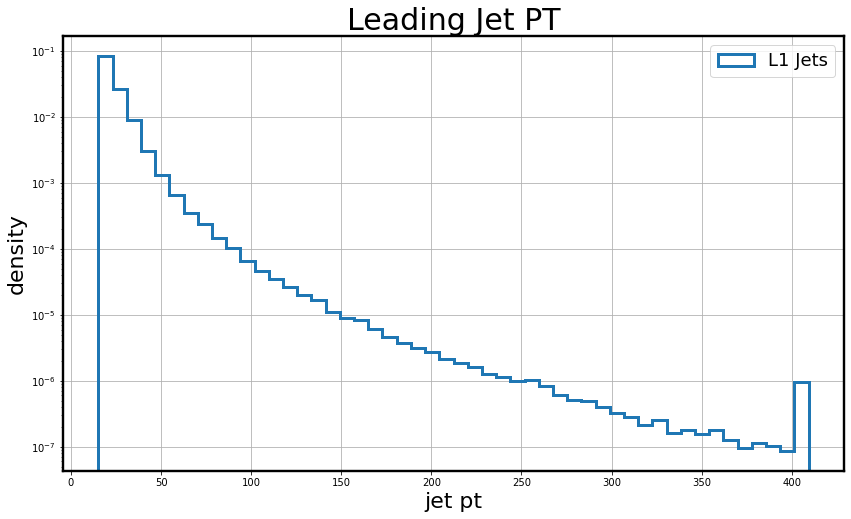

In [6]:
# Plotting pt distribtions of the jets from each dataset

plt.figure(figsize=(14, 8))
plt.rcParams['axes.linewidth'] = 2.4
#bins = np.linspace(0, 2000, 35)
bins=50

pt = topo2A_data[:, 0, 0]
nonzero_pt = pt[pt > 0]


nonzero_weights = weights[pt > 0]
plt.hist(nonzero_pt, bins=bins, label='L1 Jets', histtype='step', density=True, fill=False, linewidth=3, weights=nonzero_weights)


plt.yscale('log')
plt.xlabel('jet pt', fontsize=22)
plt.ylabel('density', fontsize=22)
plt.title('Leading Jet PT', fontsize=30)
plt.grid()
plt.legend(fontsize=18)
plt.show()

In [7]:
"""Met bias. For some events, MET was not calculated, so was written as -999.
We don't want this to impact training, so we map 0 --> 0.001 and -999 --> 0"""

# MET: 0 --> 0.001 and -999 --> 0 and nan --> 0
MET_zeros = (topo2A_data[:, 24, 0] == 0) # indices where MET=0
MET_999 = ((topo2A_data[:, 24, 0] == -999)) # indices where MET=-999 (not calculated)
MET_nan = np.isnan(topo2A_data[:, 24, 2])
topo2A_data[MET_zeros, 24, 0] = 0.001
topo2A_data[MET_999, 24, :] = 0
topo2A_data[MET_nan, 24, :] = 0

In [8]:
"""Normalize pt """

# sum of the pt and E in each event
sum_pt = np.sum(topo2A_data[:, :, 0], axis=1, keepdims=True)

# If the sum is 0, set the sum to 1 to avoid division by 0
sum_pt[sum_pt == 0] = 1

# Divide pt and E by their respective sums
topo2A_data[:, :, 0] /= sum_pt

In [9]:
print(topo2A_data.shape)

(997315, 25, 3)


In [10]:
# Flatten for use in DNN

topo2A_data = np.reshape(topo2A_data, newshape=(-1, 75))
print(topo2A_data.shape)

(997315, 75)


In [11]:
def create_AE(input_dim, h_dim_1, h_dim_2, latent_dim):
    # Encoder
    inputs = layers.Input(shape=(input_dim,))
    x = layers.Dense(h_dim_1, activation='relu')(inputs)
    x = layers.Dense(h_dim_2, activation='relu')(x)
    z = layers.Dense(latent_dim, activation='relu')(x)

    # Decoder
    x = layers.Dense(h_dim_2, activation='relu')(z)
    x = layers.Dense(h_dim_1, activation='relu')(x)
    outputs = layers.Dense(input_dim)(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

In [12]:
def loss_fn(y_true, y_pred):
    """masked mse"""
    mask0 = K.cast(K.not_equal(y_true, 0), K.floatx())
    maskMET = K.cast(K.not_equal(y_true, -999), K.floatx())
    mask = mask0 * maskMET
    squared_difference = K.square(mask * (y_pred - y_true))
    return K.mean(squared_difference)

In [13]:
# Make train, test, val splits

# TRAIN_SIZE = 0.5
# VAL_SIZE = 0.1
# TEST_1_SIZE = 0.2
# TEST_2_SIZE = 0.2

X_train, X_, weights_train, weights_, pass_L1_train, pass_L1_ = train_test_split(topo2A_data, weights, pass_L1_unprescaled, train_size=0.5)
X_val, X_, weights_val, weights_, pass_L1_val, pass_L1_ = train_test_split(X_, weights_, pass_L1_, train_size=0.2) # 0.1 of original data
X_test_1, X_test_2, weights_test_1, weights_test_2, pass_L1_test_1, pass_L1_test_2 = train_test_split(X_, weights_, pass_L1_, train_size=0.5) # 0.2 of original data

print(f'X_train: {X_train.shape}')
print(f'X_val: {X_val.shape}')
print(f'X_test_1: {X_test_1.shape}')
print(f'X_test_2: {X_test_1.shape}')

X_train: (498657, 75)
X_val: (99731, 75)
X_test_1: (199463, 75)
X_test_2: (199463, 75)


In [14]:
# Initialize model
INPUT_DIM = X_train.shape[1]
H_DIM_1 = 32
H_DIM_2 = 8
LATENT_DIM = 3
DNN_AE = create_AE(input_dim=INPUT_DIM, h_dim_1=H_DIM_1, h_dim_2=H_DIM_2, latent_dim=LATENT_DIM)
DNN_AE.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 75)]              0         
                                                                 
 dense (Dense)               (None, 32)                2432      
                                                                 
 dense_1 (Dense)             (None, 8)                 264       
                                                                 
 dense_2 (Dense)             (None, 3)                 27        
                                                                 
 dense_3 (Dense)             (None, 8)                 32        
                                                                 
 dense_4 (Dense)             (None, 32)                288       
                                                                 
 dense_5 (Dense)             (None, 75)                2475  

In [15]:
DNN_AE.compile(optimizer='adam', loss=loss_fn)

In [16]:
# Define callbacks: early stopping and learning rate scheduler

STOP_PATIENCE = 8
LR_PATIENCE = 4

early_stopping = EarlyStopping(patience=STOP_PATIENCE, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=LR_PATIENCE, verbose=1)

callbacks = [early_stopping, reduce_lr]

In [17]:
NUM_EPOCHS = 500
BATCH_SIZE = 1024

In [18]:
history = DNN_AE.fit(x=X_train, y=X_train, validation_data=(X_val, X_val), epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, callbacks=callbacks, sample_weight = weights_train)

Epoch 1/500
487/487 [==============================] - 4s 5ms/step - loss: 30338.5234 - val_loss: 0.2645 - lr: 0.0010
Epoch 2/500
487/487 [==============================] - 2s 4ms/step - loss: 24654.1426 - val_loss: 0.2550 - lr: 0.0010
Epoch 3/500
487/487 [==============================] - 2s 4ms/step - loss: 24124.8789 - val_loss: 0.2515 - lr: 0.0010
Epoch 4/500
487/487 [==============================] - 2s 4ms/step - loss: 23865.0332 - val_loss: 0.2492 - lr: 0.0010
Epoch 5/500
487/487 [==============================] - 2s 4ms/step - loss: 23637.4355 - val_loss: 0.2472 - lr: 0.0010
Epoch 6/500
487/487 [==============================] - 2s 4ms/step - loss: 23457.6895 - val_loss: 0.2456 - lr: 0.0010
Epoch 7/500
487/487 [==============================] - 2s 4ms/step - loss: 23309.4688 - val_loss: 0.2440 - lr: 0.0010
Epoch 8/500
487/487 [==============================] - 2s 4ms/step - loss: 23166.9902 - val_loss: 0.2424 - lr: 0.0010
Epoch 9/500
487/487 [==============================] - 2

In [19]:
DNN_AE.save_weights('./trained_models/EB_L1_AE_weights.keras')

In [ ]:
DNN_AE.load_weights('./trained_models/EB_L1_AE_weights.keras')

In [20]:
# Pass the test split through the model

y_true_1 = np.copy(X_test_1)
model_outputs_1 = DNN_AE.predict(X_test_1)

y_true_2 = np.copy(X_test_2)
model_outputs_2 = DNN_AE.predict(X_test_2)

6234/6234 [==============================] - 8s 1ms/step


In [21]:
def mse_loss(true, prediction):
    loss = np.mean(np.square(true - prediction), axis=-1)
    return loss

In [22]:
def AD_score(y, x):
    # masked mse
    mask = (y != 0) & (y != -999)
    _x = x * mask
    _y = y * mask
    return (mse_loss(_y, _x))

In [23]:
# Calculate the AD scores on test split and signals

AD_scores_1 = AD_score(y_true_1, model_outputs_1)
AD_scores_2 = AD_score(y_true_2, model_outputs_2)

<Figure size 1296x720 with 0 Axes>

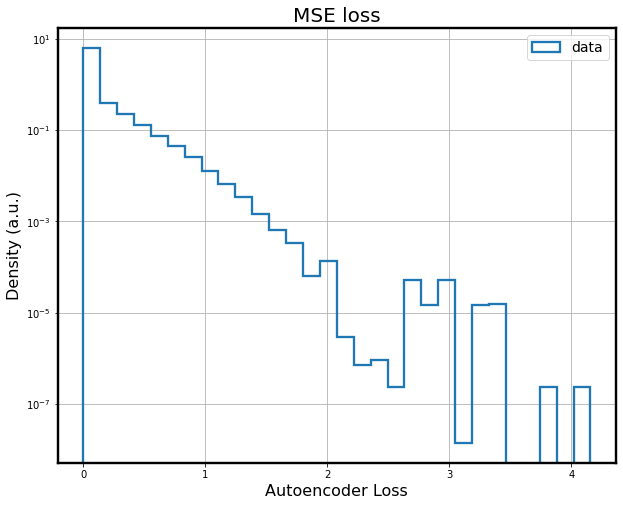

In [25]:
# Plot a histogram of the AD scores

plt.figure(figsize=(18, 10))
plt.rcParams['axes.linewidth'] = 2.4

#bins = np.linspace(0, 50000, num=30)
bins=30
plt.figure(figsize=(10,8))

plt.hist(AD_scores_1, bins=bins, label='data', density = True, histtype='step', fill=False, linewidth=2.3, weights=weights_test_1)
   

plt.yscale('log')
plt.xlabel("Autoencoder Loss", fontsize=16)
plt.ylabel("Density (a.u.)", fontsize=16)
plt.title('MSE loss', fontsize=20)
plt.legend(loc='best', fontsize=14)
plt.grid()
#plt.xlim(0, 0.2 * pow(10, 6))
plt.show()

TPR at FPR of 10^-4 is 0.0000 with threshold 2.2509
threshold FPR: 9.950046798845858e-06


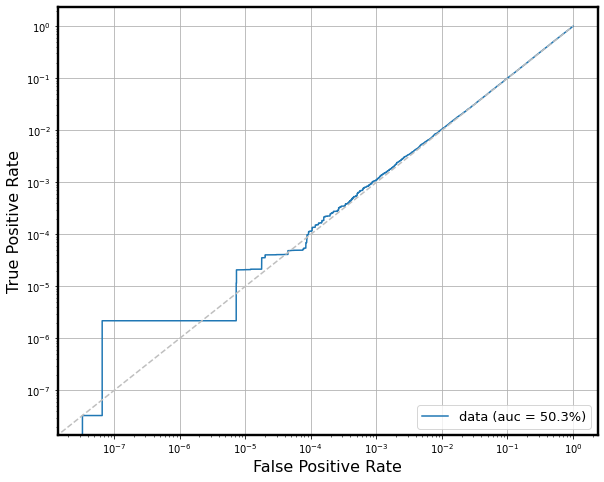

In [29]:
# Plot the ROC curves

target_background = np.zeros(AD_scores_2.shape[0])

plt.figure(figsize=(8.5,6.8))


# Combine true labels, anomaly=1 and background=0
trueVal = np.concatenate((np.ones(AD_scores_1.shape[0]), target_background))

# Combine predictions from current dataset and background
predVal_loss = np.concatenate((AD_scores_1, AD_scores_2))

sample_weights = np.concatenate((weights_test_1, weights_test_2))

# Calculate ROC curve and AUC, including weights
fpr_loss, tpr_loss, threshold_loss = roc_curve(y_true=trueVal, y_score=predVal_loss, sample_weight=sample_weights)
auc_loss = auc(fpr_loss, tpr_loss)

# Plot ROC curve
plt.plot(fpr_loss, tpr_loss, "-", label='%s (auc = %.1f%%)' % ('data', auc_loss*100.), linewidth=1.5)

# Find index where FPR is closest to 10^-5 and print TPR and threshold for that index

target_fpr = 10**-5
idx = np.argmin(np.abs(fpr_loss - target_fpr))
print(f"TPR at FPR of 10^-4 is {tpr_loss[idx]:.4f} with threshold {threshold_loss[idx]:.4f}")
print(f"threshold FPR: {fpr_loss[idx]}")
threshold = threshold_loss[idx]
plt.plot(np.linspace(0, 1), np.linspace(0, 1), '--', color='0.75')
#plt.axvline(fpr_loss[idx], color='red', linestyle='dashed', linewidth=2, label=fpr_loss[idx])  # Threshold value

# Set log scale for x and y axis
plt.semilogx()
plt.semilogy()

# Plot aesthetics and layout
plt.ylabel("True Positive Rate", fontsize=16)
plt.xlabel("False Positive Rate", fontsize=16)
plt.legend(loc='lower right', fontsize=13)
plt.grid(True)
plt.tight_layout()

# Additional plot elements

#plt.title("ROC Curve", fontsize)
plt.show()

In [37]:
"""Print the L1 overlap (the percentage of events we found as anomalous that
are already being triggered by the HLT)
and Inverse Overlap (the additional amount of signal we trigger on compared to 
just the HLT)"""


anomaly_idxs = (AD_scores_1 > threshold)
L1_overlap = 0
inverse_overlap=0


for a, h in zip(anomaly_idxs, pass_L1_test_1):
    if a==1 and h==1:
        L1_overlap += 1
        
    if a==1 or h==1:
        inverse_overlap += 1
        
L1_overlap /= np.sum(anomaly_idxs)
inverse_overlap /= np.sum(pass_L1_test_1)



print(f'L1 overlap: {L1_overlap}')
print(f'inverse overlap: {inverse_overlap}')
print(f'percentage of events that passed some L1 trigger: {np.sum(pass_L1_test_1) / len(pass_L1_test_1)}')
print(f'percentage of events that we tagged as anomalous: {np.sum(anomaly_idxs) / len(anomaly_idxs)}')
print(f'number of events that we tagged as anomalous: {np.sum(anomaly_idxs)}')

L1 overlap: 0.65
inverse overlap: 1.0001597116064707
percentage of events that passed some L1 trigger: 0.21973498844397207
percentage of events that we tagged as anomalous: 0.0001002692228633882
number of events that we tagged as anomalous: 20


In [41]:
# As a sanity check, calculate the L1 rate from our list of triggers

L1_rate = np.sum(weights_test_1 * pass_L1_test_1) / np.sum(weights_test_1)
print(f'L1 rate: {L1_rate * 40e6}')
print(f'L1 acceptance: {L1_rate}')
print(f'L1 rejection: {1/HLT_rate}')

L1 rate: 66110.81941213104
L1 acceptance: 0.001652770485303276
L1 rejection: 3020.2114156233765


In [42]:
# Calculate the additional rate added by our trigger

HLT_numerator = 0
HLT_denominator = 0
HLT_AD_numerator = 0
HLT_AD_denominator = 0


anomaly_idxs = (AD_scores_1 > threshold)
HLT_numerator += np.sum(weights_test_1 * pass_L1_test_1)
HLT_denominator += np.sum(weights_test_1)

HLT_AD_numerator += np.sum(weights_test_1 * np.bitwise_or(anomaly_idxs, pass_L1_test_1))
HLT_AD_denominator += np.sum(weights_test_1)



HLT_acceptance = HLT_numerator / HLT_denominator
HLT_AD_acceptance = HLT_AD_numerator / HLT_AD_denominator

# Multiply by 40 MHz since there are 40MHz going INTO the L1
print(f'L1 rate: {HLT_acceptance * 40e6}')
print(f'L1 + AD rate: {HLT_AD_acceptance * 40e6}')
print(f'rate added by AD: {(HLT_AD_acceptance - HLT_acceptance) * 40e6}')

L1 rate: 66110.81941213104
L1 + AD rate: 66934.12869310525
rate added by AD: 823.3092809742035


In [43]:
# Calculate the additional rate added by the AD trigger for each FPR

rates = []
overlaps = []
for i, fpr in enumerate(fpr_loss):
    threshold = threshold_loss[i]

    # Calcaulte rates
    # ----------------------------------------
    HLT_numerator = 0
    HLT_denominator = 0
    HLT_AD_numerator = 0
    HLT_AD_denominator = 0
    
    
    anomaly_idxs = (AD_scores_1 > threshold)
    HLT_numerator += np.sum(weights_test_1 * pass_L1_test_1)
    HLT_denominator += np.sum(weights_test_1)
    
    HLT_AD_numerator += np.sum(weights_test_1 * np.bitwise_or(anomaly_idxs, pass_L1_test_1))
    HLT_AD_denominator += np.sum(weights_test_1)
    
    
    
    HLT_acceptance = HLT_numerator / HLT_denominator
    HLT_AD_acceptance = HLT_AD_numerator / HLT_AD_denominator
    
    # Multiply by 40 MHz since there are 40MHz going INTO the L1
    rates.append((HLT_AD_acceptance - HLT_acceptance) * 40e6)
    # ---------------------------------------------------------

    # Calculate HLT Overlap (this takes too long to run, maybe there's a better way to do this)
    # --------------------------------------------
    # anomaly_idxs = (total_loss[0] > threshold)
    # HLT_overlap = 0
    # inverse_overlap=0

    
    # for a, h in zip(anomaly_idxs, pass_HLT_test):
    #     if a==1 and h==1:
    #         HLT_overlap += 1
        
    # HLT_overlap /= np.sum(anomaly_idxs)
    # overlaps.append(HLT_overlap)

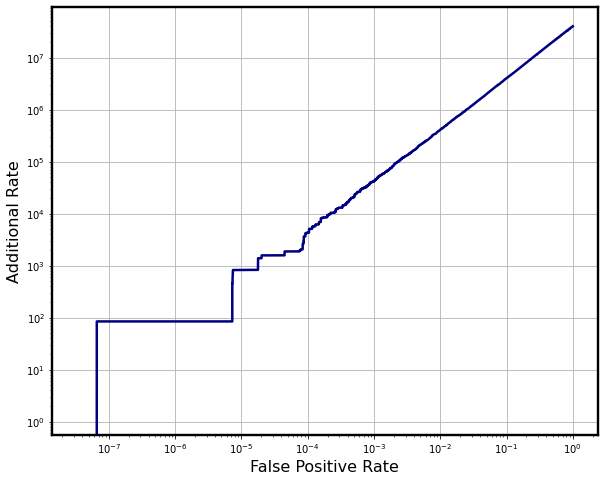

In [44]:
# Plot the additional rate vs FPR

plt.figure(figsize=(8.5,6.8))

plt.plot(fpr_loss, rates, color='navy', linewidth=2.5)

# Set log scale for x and y axis
plt.semilogx()
plt.semilogy()

# Plot aesthetics and layout
plt.ylabel("Additional Rate", fontsize=16)
plt.xlabel("False Positive Rate", fontsize=16)
#plt.legend(loc='lower right', fontsize=13)
plt.grid(True)
plt.tight_layout()

# Additional plot elements
#plt.title("ROC Curve", fontsize)
plt.show()